# Plot AIRS trends using timeseries of different lengths

We want to assess if some trends are more consistent when looking at things spectrally.

I already processed the AIRS SOLR data for the Arctic into a timeseries format (spectral_ice/proc_AIRS_arc_tseries.ipynb).

In [2]:
# from dask.distributed import Client

# client = Client()
## client = Client("tcp://127.0.0.1:43033")
# client

### Do imports

In [2]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob, copy,
    dask
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [3]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [4]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [5]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)
        _yearlydata.close()

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)
    
    t.close()
    _rvalues.close()
    _pvalues.close()
    
    return _trends,_statsig,_notnull

### Load AIRS Arctic timeseries data

In [5]:
airsarc_dir = '/glade/work/jonahshaw/obs/AIRS/arc_proc'

airs_solr_tseries = xr.open_dataarray('%s/olrspectral_70N_87N_wnumtseries.nc' % airsarc_dir)
airs_solr_clear_tseries = xr.open_dataarray('%s/olrclrspectral_70N_87N_wnumtseries.nc' % airsarc_dir)

In [6]:
# Remove the last four months of 2002 and the first 6 months of 2019 so everything starts in 2003 and ends in 2018. Sucks to discard ~1 year of data though.
airs_solr_cuttseries = airs_solr_tseries.sel(time=slice('2003-01-01','2018-12-31'))
airs_solr_clear_cuttseries = airs_solr_clear_tseries.sel(time=slice('2003-01-01','2018-12-31'))

### Compute monthly trends over the 2003-2018 Observational period.

In [6]:
def heatmap_airs_solrtrends(calculated_trends,calculated_significance,significance_threshold=95):
    '''
    Wrapper for plotting heatmaps and hasing out regions that are not statistically significant.
    '''
    
    fig_sig,ax_sig = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
    ax_sigb = ax_sig.twiny()

    statsig_thresh = 95

    mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
               '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
               }

    def tick_function1(X):
        out = ["%.0f" % z for z in X]
        return out

    def tick_function2(X):
        V = 1e4/X
        return ["%.1f" % z for z in V]

    tick_indices = np.where(calculated_trends.wnum.values % 150 == 15)[0]
    tick_values = calculated_trends.wnum[tick_indices]

    cbar_axh2 = fig_sig.add_axes([-0.14, 0.13, 0.02, 0.74])

    im = sns.heatmap(calculated_trends, center=0, cmap='vlag',ax=ax_sig,cbar_ax=cbar_axh2,vmin=-0.01,vmax=0.01)#,mask=olr_statsig_spatavg<statsig_thresh)

    zm = calculated_trends.where(calculated_significance<statsig_thresh)
    x = np.arange(0,calculated_trends.shape[1]+1)       
    y = np.arange(0,calculated_trends.shape[0]+1)
    ax_sig.pcolor(x, y, zm, hatch='////', alpha=0.)

    ax_sig.set_xticks(tick_indices)
    ax_sig.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
    ax_sig.set_yticklabels(mon_dict.values(),fontdict={'fontsize':10,'rotation':0})

    ax_sigb.set_xticks(tick_indices)
    ax_sigb.set_xbound(ax_sig.get_xbound())
    ax_sigb.set_xticklabels(tick_function2(tick_values))

    cbar = im.collections[0].colorbar
    cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)', fontsize=13)

    ax_sig.set_title('Spectral OLR Trends (70-87N)',fontsize=15)
    
    return fig_sig,ax_sig

#### Calculate trends for the full observational period.

In [7]:
solr_trends,solr_statsig,solr_notnull = compute_trends_n_signif2(airs_solr_tseries)
solrC_trends,solrC_statsig,solrC_notnull = compute_trends_n_signif2(airs_solr_clear_tseries)

#### Repeat for different end years, going back to 2012 (minimum of 10 year observational record).

In [7]:
end_yrs = ['2012','2013','2014','2015','2016','2017','2018']

for end_yr in end_yrs:
    
    # Subset temporally to the correct end year
    end_str = '%s-12-31' % end_yr # string for selection
    solr_short = airs_solr_cuttseries.sel(time=slice(None,end_str))
    
    # break
    
    # Calculate trends + significance for the 
    _solr_trends,_solr_statsig,_solr_notnull = compute_trends_n_signif2(solr_short)
    
    _fig,_ax = heatmap_airs_solrtrends(_solr_trends,_solr_statsig)
    
    _old_title = _ax.get_title()
    _new_title = 'All-sky ' + _old_title + ' (2003 - %s)' % end_yr
    _ax.set_title(_new_title)
    
    # _fig.close()
    
    # if end_yr == '2014': break

Text(0.5, 1.0, 'All-sky Spectral OLR Trends (70-87N) (2002-09 - 2019-06)')

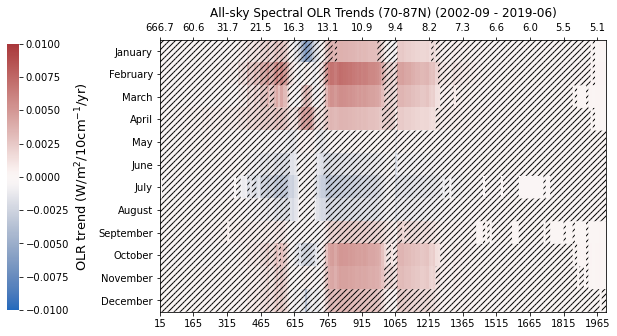

In [14]:
_fig,_ax = heatmap_airs_solrtrends(solr_trends,solr_statsig)

_old_title = _ax.get_title()
_new_title = 'All-sky ' + _old_title + ' (2002-09 - 2019-06)'
_ax.set_title(_new_title)

#### Repeat with clear-sky obs

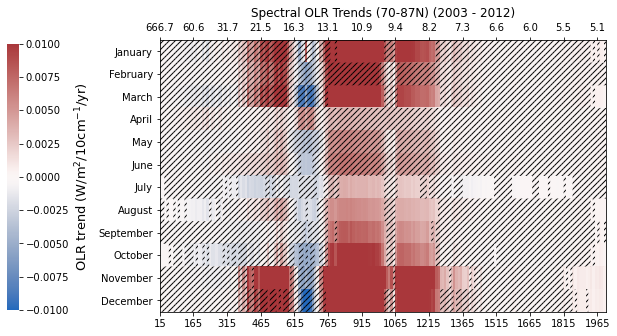

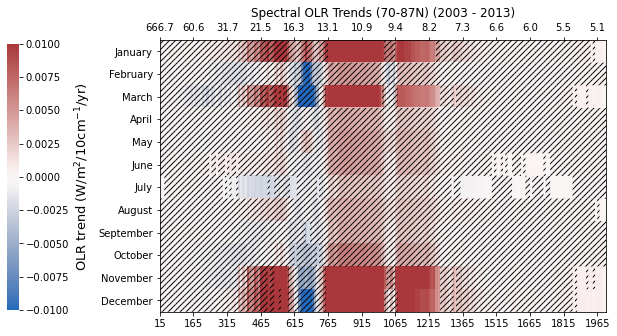

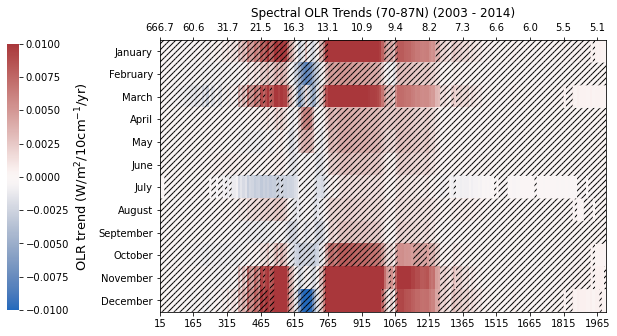

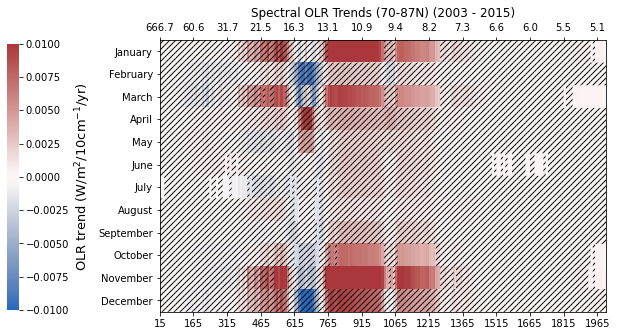

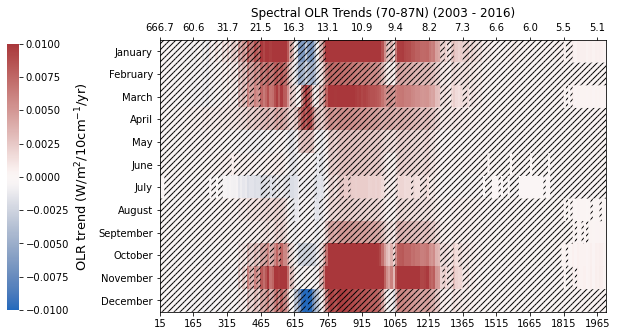

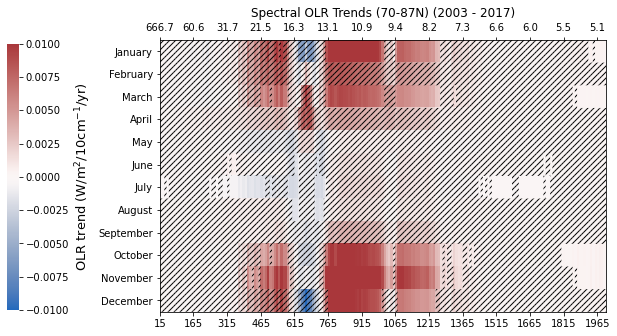

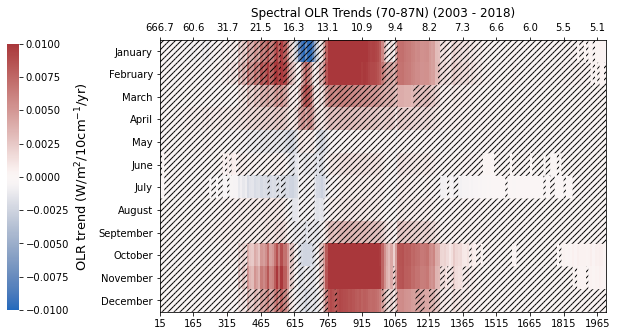

In [11]:
for end_yr in end_yrs:
    
    # Subset temporally to the correct end year
    end_str = '%s-12-31' % end_yr # string for selection
    solr_short = airs_solr_clear_cuttseries.sel(time=slice(None,end_str))
    
    # break
    
    # Calculate trends + significance for the 
    _solr_trends,_solr_statsig,_solr_notnull = compute_trends_n_signif2(solr_short)
    
    _fig,_ax = heatmap_airs_solrtrends(_solr_trends,_solr_statsig)
    
    _old_title = _ax.get_title()
    _new_title = 'Clear-sky ' + _old_title + ' (2003 - %s)' % end_yr
    _ax.set_title(_new_title)
    
    # _fig.close()
    
    # if end_yr == '2014': break

Text(0.5, 1.0, 'Clear-sky Spectral OLR Trends (70-87N) (2002-09 - 2019-06)')

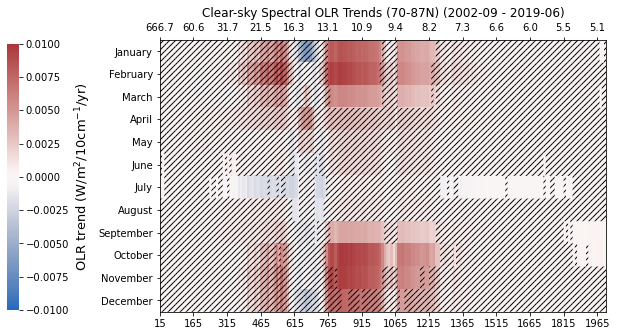

In [15]:
_fig,_ax = heatmap_airs_solrtrends(solrC_trends,solrC_statsig)

_old_title = _ax.get_title()
_new_title = 'Clear-sky ' + _old_title + ' (2002-09 - 2019-06)'
_ax.set_title(_new_title)

#### Let's aggregate over the window channels and see how things look

Here I will do a heatmap similar to one from an old paper of Jen's. Duration of trend on the x-axis and month on the y-axis with the significance in the color dimension.

In [8]:
def is_window(wnum):
    '''
    Function to use with .sel() to subset AIRS spectral OLR data and select a "window" region.
    '''
    window = [765.,  775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
              865.,  875.,  885.,  895.,  905.,  915.,  925.,  935.,  945.,  955.,
              965.,  975.,  985.,  995., 1005., 1075., 1085., 1095., 1105., 1115.,
              1125., 1135., 1145., 1155., 1165., 1175., 1185., 1195., 1205., 1215.,
              1225., 1235.] #, 1935., 1955., 1965., 1975., 1985., 1995.]
    
    return np.isin(wnum,window)
    # return ((wnum >= 760) & (month <= 1010)) | ((wnum >= 1070) & (month <= 1240))

In [9]:
def is_jfm(times):
    '''
    Function to use with xarray.sel to grab only January, February and March
    '''
    
    jfm = [1,2,3]
    
    return np.isin(times['time.month'],jfm)
    

In [10]:
Awindow = [765.,  775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
              865.,  875.,  885.,  895.,  905.,  915.,  925.,  935.,  945.,  955.,
              965.,  975.,  985.,  995., 1005., 1075., 1085., 1095., 1105., 1115.,
              1125., 1135., 1145., 1155., 1165., 1175., 1185., 1195., 1205., 1215.,
              1225., 1235.]

In [12]:
# Create timeseries just for the Awindow
airs_Awindow_cuttseries = airs_solr_cuttseries.sel(wnum=Awindow).mean('wnum')
airs_clear_Awindow_cuttseries = airs_solr_clear_cuttseries.sel(wnum=Awindow).mean('wnum')

In [13]:
# iterate over end years, subselect, calculate trends and significance, and plot both via heatmaps
solr_trends   = []
solr_statsig  = []
Csolr_trends  = []
Csolr_statsig = []

for end_yr in end_yrs:
    
    # Subset temporally to the correct end year
    end_str = '%s-12-31' % end_yr # string for selection
    solr_short  = airs_Awindow_cuttseries.sel(time=slice(None,end_str))
    Csolr_short = airs_clear_Awindow_cuttseries.sel(time=slice(None,end_str))
    
    # break
    
    # Calculate trends + significance for the 
    _solr_trends,_solr_statsig,_solr_notnull = compute_trends_n_signif2(solr_short)
    _Csolr_trends,_Csolr_statsig,_Csolr_notnull = compute_trends_n_signif2(Csolr_short)
    
    _solr_trends['endyear']   = int(end_yr)
    _solr_statsig['endyear']  = int(end_yr)
    _Csolr_trends['endyear']  = int(end_yr)
    _Csolr_statsig['endyear'] = int(end_yr)
    
    solr_trends.append(_solr_trends)
    solr_statsig.append(_solr_statsig)
    Csolr_trends.append(_Csolr_trends)
    Csolr_statsig.append(_Csolr_statsig)
    
Awindow_allsky_trends   = xr.concat(solr_trends,dim='endyear')
Awindow_allsky_statsig  = xr.concat(solr_statsig,dim='endyear')
Awindow_clrsky_trends   = xr.concat(Csolr_trends,dim='endyear')
Awindow_clrsky_statsig  = xr.concat(Csolr_statsig,dim='endyear')
    # break

In [ ]:
sns.choose_cubehelix_palette()

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8888663743660877, 0.7106793139856472, 0.7158661451411206],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.7588951019517731, 0.49817117746394224, 0.6058723814510268],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.5529215689527474, 0.3217924564263954, 0.5093718054521851],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.29794615023641036, 0.18145907625614888, 0.35317781405034754],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [34]:
def heatmap_monthly_sigtrends(calculated_significance,title='Significance of Atmospheric Window OLR Trends (70-87N)'):
    '''
    Wrapper for plotting heatmaps and hasing out regions that are not statistically significant.
    '''
    
    fig_sig,ax_sig = plt.subplots(nrows=1,ncols=1,figsize=(7,5))

    statsig_thresh = 95

    mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
               '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
               }

    def tick_function1(X):
        out = ["%.0f" % z for z in X]
        return out

    def tick_function2(X):
        V = 1e4/X
        return ["%.1f" % z for z in V]
    
    # Create custom colormap. Not as cmap because we want discrete levels for easier reading.
    sig_cmap = sns.cubehelix_palette(n_colors=8,start=0,rot=0.4,gamma=1,hue=0.8,light=0.85,dark=0.15,as_cmap=False)
    
    # Transpose if month isn't the first dimension
    if calculated_significance.dims[1] == 'month':
        calculated_significance = calculated_significance.T

    cbar_axh2 = fig_sig.add_axes([-0.14, 0.13, 0.02, 0.74])

    im = sns.heatmap(calculated_significance,ax=ax_sig,cbar_ax=cbar_axh2,cmap=sig_cmap,vmin=80,vmax=100) # Create plot

    ax_sig.set_xticklabels(tick_function1(calculated_significance['endyear']))
    ax_sig.set_xlabel('Trend Endyear')
    ax_sig.set_yticklabels(mon_dict.values(),fontdict={'fontsize':10,'rotation':0})

    ax_sigb = ax_sig.twiny() 
    # Twinning the axis doesn't copy over everything apparently. Need to copy tick values.
    ax_sigb.set_xlim(ax_sig.get_xlim())
    ax_sigb.set_xticks(ax_sig.get_xticks())
    
    ax_sigb.set_xticklabels(tick_function1(calculated_significance['endyear'] - 2002))
    ax_sigb.set_xlabel('Trend Duration (yrs)')

    cbar = im.collections[0].colorbar
    cbar.set_label('Trend Significance (%)', fontsize=13)

    ax_sig.set_title(title,fontsize=15)
    
    return fig_sig,ax_sig

(<Figure size 504x360 with 3 Axes>,
 <AxesSubplot:title={'center':'Significance of Atmospheric Window OLR Trends (70-87N)'}, xlabel='Trend Endyear'>)

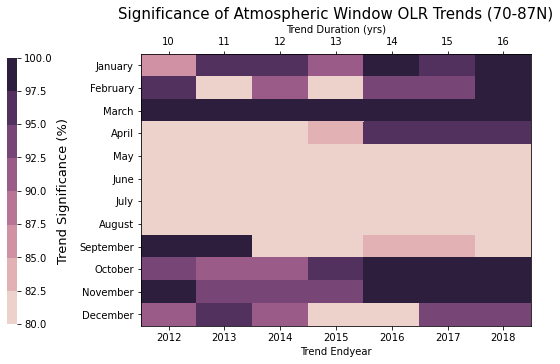

In [78]:
heatmap_monthly_sigtrends(Awindow_allsky_statsig)

(<Figure size 504x360 with 3 Axes>,
 <AxesSubplot:title={'center':'Significance of Atmospheric Window OLR Trends (70-87N)'}, xlabel='Trend Endyear'>)

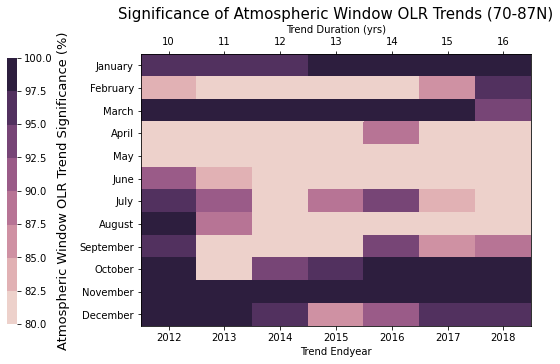

In [76]:
heatmap_monthly_sigtrends(Awindow_clrsky_statsig)

In [39]:
solr_Awindow_trends,solr_Awindow_statsig,solr_Awindow_notnull = compute_trends_n_signif2(airs_Awindow_tseries.mean('wnum'))


### Now I just need to repeat this for the CERES broadband OLR trends

Use the same observational period as AIRS so that the significance of trends can be directly compared.

In [19]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'
ceres_olr = add_weights(xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir))

In [22]:
ceres_arc_interp = ceres_olr['OLR'].interp(lat=np.arange(70,87.1,1)) # interpolate to same latitudinal resolution as AIRS data

In [24]:
# Average spatially to produce an OLR timeseries.
ceres_olr_arctseries = ceres_arc_interp.weighted(ceres_arc_interp['cell_weight']).mean(dim=['lat','lon'])

In [27]:
# Cut the full CERES tseries to only start when AIRS starts
ceres_olr_arc_cuttseries = ceres_olr_arctseries.sel(time=slice('2003-01-01',None))

In [38]:
# iterate over end years, subselect, calculate trends and significance, and plot both via heatmaps
ceres_olr_trends   = []
ceres_olr_statsig  = []

end_yrs = ['2012','2013','2014','2015','2016','2017','2018']#,'2019','2020']

for end_yr in end_yrs:
    
    # Subset temporally to the correct end year
    end_str = '%s-12-31' % end_yr # string for selection
    olr_short  = ceres_olr_arc_cuttseries.sel(time=slice(None,end_str))
    
    
    # Calculate trends + significance for the 
    _olr_trends,_olr_statsig,_olr_notnull = compute_trends_n_signif2(olr_short)
    
    _olr_trends['endyear']   = int(end_yr)
    _olr_statsig['endyear']  = int(end_yr)

    
    ceres_olr_trends.append(_olr_trends)
    ceres_olr_statsig.append(_olr_statsig)

ceres_allsky_trends   = xr.concat(ceres_olr_trends,dim='endyear')
ceres_allsky_statsig  = xr.concat(ceres_olr_statsig,dim='endyear')
    # break

(<Figure size 504x360 with 3 Axes>,
 <AxesSubplot:title={'center':'CERES Broadband OLR Trends (70-87N)'}, xlabel='Trend Endyear'>)

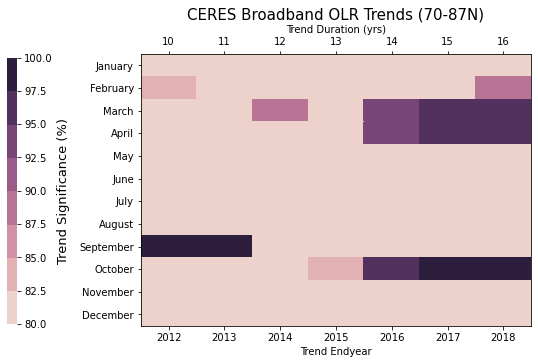

In [39]:
heatmap_monthly_sigtrends(ceres_allsky_statsig,title='CERES Broadband OLR Trends (70-87N)')

(<Figure size 504x360 with 3 Axes>,
 <AxesSubplot:title={'center':'CERES Broadband OLR Trends (70-87N)'}, xlabel='Trend Endyear'>)

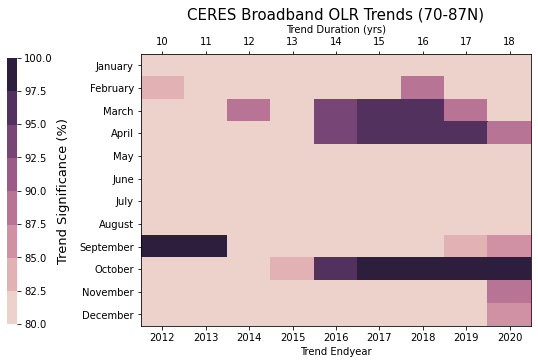

In [37]:
heatmap_monthly_sigtrends(ceres_allsky_statsig,title='CERES Broadband OLR Trends (70-87N)')